Block diagram using pipelines:

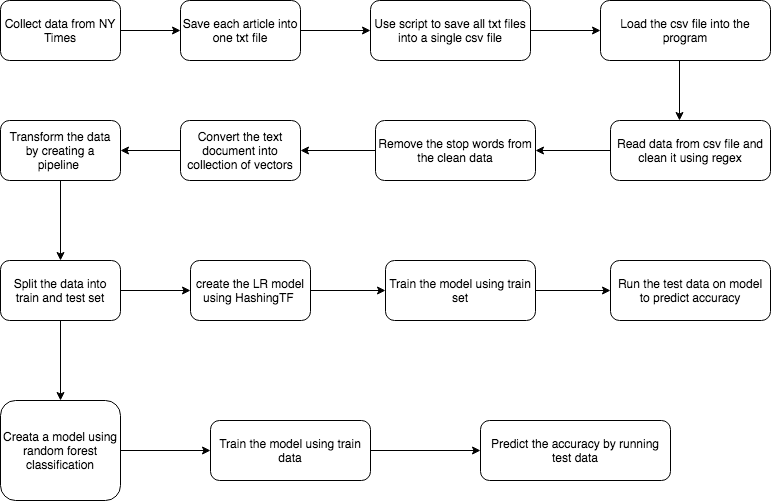

In [468]:
from IPython.display import Image
Image("BlockDiagram.png")

In [469]:
import pyspark
import pyspark.sql.functions as fcn
from pyspark.sql.functions import udf
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier

-------
We Converted all the text files collected into a single csv file, with Category and Article as columns. (from t2csv.py script)

Text files were saved in the format of Category_[0-60].txt. 

Categories consist of ['Politics', 'Sports', 'Technology', "Business'].
                       
We downloaded one essay into a single text file and storing that text file in a single row.

Now, loading the original dataset into data spark instance and unknown dataset into data2 spark instance

In [470]:
data = spark.read.format("csv").option("header", "true").load("originalData.csv")

#Unknown data
data2 = spark.read.format("csv").option("header", "true").load("unknownData.csv")

---------
Checking the first five articles, with labels in Category column and data in Articles column.

In [411]:
#Checking the first five articles, with labels in Category column and data in Articles column.

data.head(5)

[Row(Category='Sports', Article='"Advertisement Supported by By The Associated Press An NFL team in London? Count on it. An NBA franchise in Mexico City? Yep, that\'s coming too. What was once a pipe dream ‚Äî major-league teams based in cities outside the United States and Canada ‚Äî is now just a matter of time. The aforementioned cities are the ones most likely to break through first, but others will surely follow when everyone sees how much potential revenue is there for the taking. ""The market is saturated in the U.S.'),
 Row(Category='Sports', Article='"Advertisement By THE ASSOCIATED PRESSAPRIL 26, 2018, 6:01 P.M. E.D.T.  CLEVELAND ‚Äî  The NBA said LeBron James\' block in the closing seconds of Game 5 on Indiana\'s Victor Oladipo should have been called goaltending. In the league\'s Last Two Minute Report posted Thursday, the NBA said the three officials missed the call with 5.1 seconds left. The league said the video shows James blocked Oladipo\'s shot ""after it makes contac

In [412]:
#Unknown Data

data2.head(2)

[Row(Category='Technology', Article="Advertisement With Andrew Ross Sorkin MAY 9, 2018   Good Wednesday. Here’s what we’re watching: • How well did Flipkart’s investors do? • What did AT&T and Novartis want from Michael Cohen? • Walmart finally announced a deal to buy control of Flipkart for about $16 billion. • What the U.S.’s withdrawal from the Iran nuclear deal means for the business world. • The bottom line on Vodafone’s big deal with Liberty Global. Get this in your inbox each morning. Sign up here. The story of Walmart’s $16 billion deal for Flipkart began nearly two years ago and spanned secret negotiations in both Bentonville, Ark., and Bangalore, India. Here’s an account of how it came together based on interviews by people involved in the transaction, who were not authorized to speak publicly about the deal. Driving the deal was the retail giant’s push to bolster its presences in e-commerce and emerging markets like India. In recent years, Walmart had bought Jet.com and Bono

------------
Checking the columns of original dataset and unknown dataset

In [438]:
data.columns

['Category', 'Article']

Printing the schema of the dataframe

In [439]:
data.printSchema()

root
 |-- Category: string (nullable = true)
 |-- Article: string (nullable = true)



-------------------------------------------
Printing the count of original data.

It shows the total counts of articles in each category

In [440]:
from pyspark.sql.functions import col

# using the sql function to display the count of each Category column label.

data.groupBy("Category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+----------+-----+
|  Category|count|
+----------+-----+
|    Sports|   60|
|  Politics|   60|
|Technology|   59|
|  Business|   59|
+----------+-----+



---------------
Printing the count of original data.

It shows the total counts of articles in each category

In [441]:
#Unknown data count

from pyspark.sql.functions import col

# using the sql function to display the count of each Category column label.

data2.groupBy("Category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+----------+-----+
|  Category|count|
+----------+-----+
|    Sports|   10|
|Technology|   10|
|  Business|   10|
|  Politics|   10|
+----------+-----+



-------------------
Regular expression tokenizer

It extracts the tokens by matching the pattern provided which states not to process non-word characters (words containing only small and large alphabets)

In [471]:
regexToken = RegexTokenizer(inputCol="Article", outputCol="words", pattern="[^a-zA-Z.]+")

-------------------
stop words

We took the list of stop words from NLTK and implemented it by putting in a list.

StopWordsRemover takes as input the list of stop words and drop all the stop words from the input sequence.

stopwordsRemover calls the setStopWords function, which takes the list of stop words as input

In [472]:
list_stopwords = ["advertisement","ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"]
stopwordsRemoved = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(list_stopwords)

---------------------------
Document-term vectors

CountVectorizer aim to help convert a collection of text documents to vectors of token counts. It takes input the filtered words after removing stop words.

CountVectorizer can be used as an Estimator to extract the vocabulary, and this model produces sparse representations for the documents over the vocabulary, which can then be passed to Machine Learning algorithms.

During the fitting process, CountVectorizer will select the top vocabSize words ordered by term frequency across the corpus. 

An optional parameter minDF also affects the fitting process by specifying the minimum number (or fraction if < 1.0) of documents a term must appear in to be included in the vocabulary.

In [473]:
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=1000, minDF=4)

-------
StringIndexer encodes a string column of labels to a column of label indices.

The indices are ordered by label frequencies, so the most frequent label gets index 0.

In [474]:
label_Idx = StringIndexer(inputCol = "Category", outputCol = "label")

---------
Pipeline API make it easier to combine machine learning algorithms into a single pipeline, or workflow.

A Pipeline is specified as a sequence of stages, and each stage is either a Transformer or an Estimator. These stages are run in order, and the input DataFrame is transformed as it passes through each stage.

Pipeline makes a sequence in which it first picks only words matching the regular expression, and then drops the stop words from it, and then converts it into a vectors of token counts and then orders it according to label frequency.

In [1]:
pipeline = Pipeline(stages=[regexToken, stopwordsRemoved, countVectors, label_Idx])

NameError: name 'Pipeline' is not defined

-----
Fit the pipeline to training documents.

For Estimator stages, the fit() method is called to produce a Transformer.

In [476]:
pipelineFit = pipeline.fit(data)

-------
For Transformer stages, the transform() method is called on the DataFrame.

In [477]:
dataset = pipelineFit.transform(data)
dataset.show(5)

+----------+--------------------+--------------------+--------------------+--------------------+-----+
|  Category|             Article|               words|            filtered|            features|label|
+----------+--------------------+--------------------+--------------------+--------------------+-----+
|    Sports|"Advertisement Su...|[advertisement, s...|[supported, assoc...|(1000,[8,14,23,30...|  1.0|
|    Sports|"Advertisement By...|[advertisement, b...|[associated, pres...|(1000,[2,7,19,20,...|  1.0|
|    Sports|Advertisement By ...|[advertisement, b...|[sarah, lyalljune...|(1000,[2,4,6,7,9,...|  1.0|
|Technology|Advertisement By ...|[advertisement, b...|[nathaniel, poppe...|(1000,[0,2,4,6,7,...|  2.0|
|Technology|Advertisement Sup...|[advertisement, s...|[supported, justi...|(1000,[1,3,4,5,6,...|  2.0|
+----------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



------
Repeating the pipeline ( Regular expression tokenizer, Removing Stop words, Creating Document-term vector and String Indexing) for the unknown dataset

In [478]:
#Unknown Data part

label_Idx = StringIndexer(inputCol = "Category", outputCol = "label")
pipeline = Pipeline(stages=[regexToken, stopwordsRemoved, countVectors, label_Idx])
pipelineFit = pipeline.fit(data2)
dataset2 = pipelineFit.transform(data2)
dataset2.show(5)

+----------+--------------------+--------------------+--------------------+--------------------+-----+
|  Category|             Article|               words|            filtered|            features|label|
+----------+--------------------+--------------------+--------------------+--------------------+-----+
|Technology|Advertisement Wit...|[advertisement, w...|[andrew, ross, so...|(978,[0,1,2,3,4,6...|  0.0|
|Technology|Advertisement Wit...|[advertisement, w...|[andrew, ross, so...|(978,[0,1,2,3,4,7...|  0.0|
|  Business|Advertisement Wit...|[advertisement, w...|[andrew, ross, so...|(978,[0,1,2,3,4,6...|  1.0|
|  Business|Advertisement Sup...|[advertisement, s...|[supported, reute...|(978,[2,7,8,18,19...|  1.0|
|    Sports|"Advertisement Su...|[advertisement, s...|[supported, assoc...|(978,[31,39,44,48...|  3.0|
+----------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



-------
Spliting the train and test set in the ratio of 8:2

randomSplit sorts the data also.

In [479]:
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 188
Test Dataset Count: 50


-----
Logistic Regression using TF-IDF Features

It is a feature vectorization method widely used in text mining to reflect the importance of a term to a document in the corpus.

for HashingTF function, we are using the filtered words as input and we are setting numFeatures as 100, which are the top 100 words.

We are splitting the data into train and test in 70:30 ratio, and apply logistic regession on it.

We get the linear model from the regression technique.

For multiclass classification problems, the algorithm will output a multinomial logistic regression model, which contains K−1 binary logistic regression models regressed against the first class

Given a new data points, K-1 models will be run, and the class with largest probability will be chosen as the predicted class.

After this, we get the output as prediction column, which we will use to find the accuracy.

In [480]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=100)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=4) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(data)
dataset = pipelineFit.transform(data)
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+------------------------------+-----+----------+
|  Category|                       Article|                   probability|label|prediction|
+----------+------------------------------+------------------------------+-----+----------+
|  Politics|Advertisement Supported by ...|[0.9999029715566995,1.17921...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.9698636615551215,0.00641...|  0.0|       0.0|
|  Politics|Advertisement By PETER BAKE...|[0.9296116187129979,0.01456...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.831042366373529,0.024994...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.8039636175359777,0.01849...|  0.0|       0.0|
|  Politics|Advertisement By JULIE HIRS...|[0.7438007125937856,0.03651...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.7293014702641053,0.09801...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6501869763359533,0.09226...|  0.0|

-------
Finding the accuracy.

We use the MulticlassClassificationEvaluator function which expects prediction as input column.

It evaluates the accuracy and displays it.

In [481]:
predictor = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = predictor.evaluate(predictions)
acc = acc*100
print("Accuracy using Logitic Regression for original dataset: "+str(acc)+ "%")

Accuracy using Logitic Regression for original dataset: 80.12967032967035%


--------
Finding the prediction of unknown dataset using the same Logistic Regession model we trained for the original dataset.

In [482]:
#For Unknown articles
#fitting the unknown data into pipeline
dataset2 = pipelineFit2.transform(data2)

#using the previously trained model (lrModel) to test the unknown data
predictions = lrModel.transform(dataset2)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+------------------------------+-----+----------+
|  Category|                       Article|                   probability|label|prediction|
+----------+------------------------------+------------------------------+-----+----------+
|  Politics|Advertisement Supported by ...|[0.9860742706477363,0.00293...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.9757498687641549,0.00128...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.9394175954850477,0.01055...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.8749880174273361,0.02384...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.8423568851440592,0.01627...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.8150498692497954,0.07461...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.8097224357978611,0.04019...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6883056221095619,0.02860...|  0.0|

-----
Finding the accuracy of unknown dataset

In [483]:
#Finding the accuracy of unknown dataset
predictor2 = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = predictor2.evaluate(predictions)
acc = acc*100
print("Accuracy using Logistic Regression for unknown dataset: "+str(acc)+"%")

Accuracy using Logistic Regression for unknown dataset: 82.40079365079364%


-----
Random Forest classification

Random forests are a popular family of classification and regression methods.

Random forests combine many decision trees in order to reduce the risk of overfitting.

We load the data, split it into training and test sets, train on the first dataset, and then evaluate on the held-out test set.

We get the prediction column as output, which we will use to predict the accuracy.

In [484]:
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+------------------------------+-----+----------+
|  Category|                       Article|                   probability|label|prediction|
+----------+------------------------------+------------------------------+-----+----------+
|  Politics|Advertisement Supported by ...|[0.7445596856556513,0.03413...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.7240775126267386,0.09646...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.7139092882774234,0.06765...|  0.0|       0.0|
|  Politics|Advertisement By JULIE HIRS...|[0.697917721498919,0.067886...|  0.0|       0.0|
|  Politics|Advertisement By PETER BAKE...|[0.6446334455336835,0.06710...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6232331865995642,0.03444...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6059793803163533,0.10306...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.5990336206291234,0.07150...|  0.0|

------
Finding the accuracy of the original dataset.

We use the MulticlassClassificationEvaluator function which expects prediction as input column.

It evaluates the accuracy and displays it.

In [485]:
predictor = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = predictor.evaluate(predictions)
acc = acc*100
print("Accuracy using random forest classification for original dataset:"+str(acc)+"%")

Accuracy using random forest classification for original dataset:68.58410794602699%


------
Running the Random forest classification for unknown dataset.

Using the previously trained model (rfModel) and using the unknown dataset (dataset2).

In [486]:
predictions = rfModel.transform(dataset2)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+----------+------------------------------+------------------------------+-----+----------+
|  Category|                       Article|                   probability|label|prediction|
+----------+------------------------------+------------------------------+-----+----------+
|  Politics|Advertisement Supported by ...|[0.7859806964238746,0.04553...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.663949335187096,0.054954...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6568154539117075,0.07551...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6175858287049832,0.04229...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.6088525257222955,0.04707...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.5850689641053561,0.03452...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.5842410769719546,0.08842...|  0.0|       0.0|
|  Politics|Advertisement Supported by ...|[0.5680871773349483,0.07809...|  0.0|

----
Finding the accuracy of unknown dataset

In [487]:
#Accuracy of unknown dataset
predictor = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = predictor.evaluate(predictions)
acc = acc*100
print("Accuracy using random forest classification for unknown dataset:"+str(acc)+"%")

Accuracy using random forest classification for unknown dataset:70.89947089947091%


-----
Naive Bayes is a simple multiclass classification algorithm with the assumption of independence between every pair of features. 

We use the fit() function for training the model.

And then we use transform() fucntion for testing the data.

In [488]:
nb = NaiveBayes(smoothing=1)
model = nb.fit(trainingData)
predictions = model.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+--------+------------------------------+------------------------------+-----+----------+
|Category|                       Article|                   probability|label|prediction|
+--------+------------------------------+------------------------------+-----+----------+
|Politics|Advertisement Supported by ...|[1.0,1.9480613999237928E-41...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999893180819531,5.86695...|  0.0|       0.0|
|Politics|Advertisement By PETER BAKE...|[0.9999788777095214,4.51232...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999539944882296,9.59348...|  0.0|       0.0|
|Politics|Advertisement By JULIE HIRS...|[0.9998728881103541,3.59165...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9998287422450305,3.22501...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.998294954423793,2.594688...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9931516761032051,3.74993...|  0.0|       0.0|
|Politics|

-----
Finding the accuracy of original dataset

In [489]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(predictions)
acc = acc*100
print("Accuracy using Naive Bayes classification for original dataset:"+str(acc)+"%")

Accuracy using Naive Bayes classification for original dataset:94.04466501240695%


-----
Running the Naive Bayes classification for unknown dataset using the trained model from original dataset.

In [490]:
predictions = model.transform(dataset2)
predictions.filter(predictions['prediction'] == 0) \
    .select("Category","Article","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+--------+------------------------------+------------------------------+-----+----------+
|Category|                       Article|                   probability|label|prediction|
+--------+------------------------------+------------------------------+-----+----------+
|Politics|Advertisement Supported by ...|[0.999999820522941,1.926520...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999996682899769,2.35828...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999956978885135,3.33297...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999926778497812,2.24858...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999679375344425,9.30633...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9999291187654024,1.20613...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.9997869346685494,3.22136...|  0.0|       0.0|
|Politics|Advertisement Supported by ...|[0.999679576225893,4.218939...|  0.0|       0.0|
|Politics|

----
Finding the accuracy of the unknown dataset.

In [491]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(predictions)
acc = acc*100
print("Accuracy using Naive Bayes classification for unknown dataset:"+str(acc)+"%")

Accuracy using Naive Bayes classification for unknown dataset:79.28524374176547%


------
As we can see from the above results, we evaluate 3 models using the same datasets, and the accuracies are shown below for each of the three models-

Classifier           |  Original(%)  |   Unknown(%)

Logistic Regression  |  80.12        |   82.40

Random Forest        |  68.58        |   70.89

Naive Bayes          |  94.04        |   79.28

From the above table, we can infer that the accuracies are the highest for the Naive Bayes Classifier.

We can further boost up the accuracy for the model by increasing the size of the training data set, hence training a better model.

--------
References:

HashingTF: https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html#pyspark.ml.feature.HashingTF

Multi-class classification implementation with pipeline: https://towardsdatascience.com/multi-class-text-classification-with-pyspark-7d78d022ed35

TF-IDF: https://spark.apache.org/docs/2.1.0/ml-features.html#tf-idf

Logistic Regession: https://spark.apache.org/docs/2.2.0/mllib-linear-methods.html#logistic-regression

Random Forest classification: https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#random-forest-classifier

Naive Bayes: https://spark.apache.org/docs/latest/mllib-naive-bayes.html

ML pipelines: https://spark.apache.org/docs/2.1.0/ml-pipeline.html

Scraping NY Times articles using API: http://dlab.berkeley.edu/blog/scraping-new-york-times-articles-python-tutorial